[Original Link](https://www.kaggle.com/code/leventelippenszky/train-vesuvius-challenge-3d-ink-classifier)
This notebook extends the [tutorial notebook](https://www.kaggle.com/code/jpposma/vesuvius-challenge-ink-detection-tutorial) created by the organizers, added features:
* train and validation split using matrix and morphological operations
* animations of label 0 and 1 subvolumes that go into the network
* integrated Weights & Biases for experiment tracking
* added Dice score calculation

In [1]:
import os
import gc
from celluloid import Camera
import numpy as np
from PIL import Image
from typing import List, Tuple
from celluloid import Camera
from IPython.display import HTML, display
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage.morphology import binary_erosion, binary_dilation
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch import Tensor
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import wandb
WANDB_API_KEY = 'local-a2cc501204f722abe273d32f382f7b7438873ad7'
wandb.login(host='http://192.168.0.225:8080', key=WANDB_API_KEY)

C:\Users\gamer\.conda\envs\vesuvius\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\gamer\.conda\envs\vesuvius\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\gamer\.conda\envs\vesuvius\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\gamer\AppData\Local\Temp\ipykernel_19924\2956729290.py:11: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, binary_dilation
C:\Users\gamer\AppData\Local\Temp\ipykernel_19924\2956729290.py:11: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, bin

True

In [2]:
DATA_DIR = "../../data"
TRAIN_DIR = "../../data/train"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
NUM_SLICES = 65
IMAGE_SHAPE = 8181, 6330
DEBUG = False

config = {"seed": 1337,
          "subvolume_size": 30,
          "z_start": 27,
          "z_dim": 10,
          "batch_size": 64,
          "train_rounds": 4,  # 6
          "train_steps": 4000}

EXPERIMENT_NAME = f"3Dclf-subv_{config['subvolume_size']}-zstrt_{config['z_start']}-zdim_{config['z_dim']}-bs_{config['batch_size']}-round_{config['train_rounds']}-step_{config['train_steps']}"

cuda


In [3]:
def set_seed(seed):
    """
    Sets the seed of the entire notebook for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # when running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    
set_seed(config["seed"])

## Utils

In [4]:
def load_png(fragment_id: str, png_name: str) -> np.ndarray:
    fragment_dir = os.path.join(TRAIN_DIR, fragment_id)
    path = os.path.join(fragment_dir, f"{png_name}.png")
    image = Image.open(path)
    return np.array(image)


def show_array(array: np.ndarray, name: str, ax, off=True):
    ax.imshow(array, cmap="gray")
    if off:
        ax.axis("off")
    ax.set_title(f"{name}, shape: {array.shape}")


def show_pngs(mask: np.ndarray, inklabels: np.ndarray, ir: np.ndarray):
    plt.style.use("default")
    plt.rcParams["figure.dpi"] = 100
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 12))
    axs.flatten()
    show_array(mask, "mask", axs[0])
    show_array(inklabels, "inklabels", axs[1])
    show_array(ir, "ir", axs[2])


def show_rect_on_inklabels(rect: dict, inklabels: np.ndarray):
    plt.style.use("default")
    fig, ax = plt.subplots()
    show_array(inklabels, "inklabels", ax, off=False)
    patch = Rectangle(xy=(rect["x"], rect["y"]), width=rect["width"], height=rect["height"], linewidth=2, edgecolor="red", facecolor="none")
    ax.add_patch(patch)
    plt.show()


def load_volume(fragment_id: str, z_start: int, z_dim: int) -> np.ndarray:
    volume_dir = os.path.join(TRAIN_DIR, fragment_id, "surface_volume")
    volume = []
    for i in range(z_start, z_start + z_dim):
        slice_path = os.path.join(volume_dir, f"{i:02d}.tif")
        slice_png = Image.open(slice_path)
        # normalize pixel intesity values into [0,1]
        slice_array = np.array(slice_png, dtype=np.float32) / 65535.0
        volume.append(slice_array)
    return np.stack(volume, axis=0)


class AverageCalc:
    """
    Calculates and stores the average and current value.
    Used to update the loss.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, value, size):
        self.value = value
        self.sum += value * size
        self.count += size
        self.avg = self.sum/self.count

class DummyLogger:
    def log(self, message):
        pass

    def finish(self):
        pass

def create_logger(config: dict):
    logger = wandb.init(project="Vesuvius", name=EXPERIMENT_NAME, config=config)
    return logger

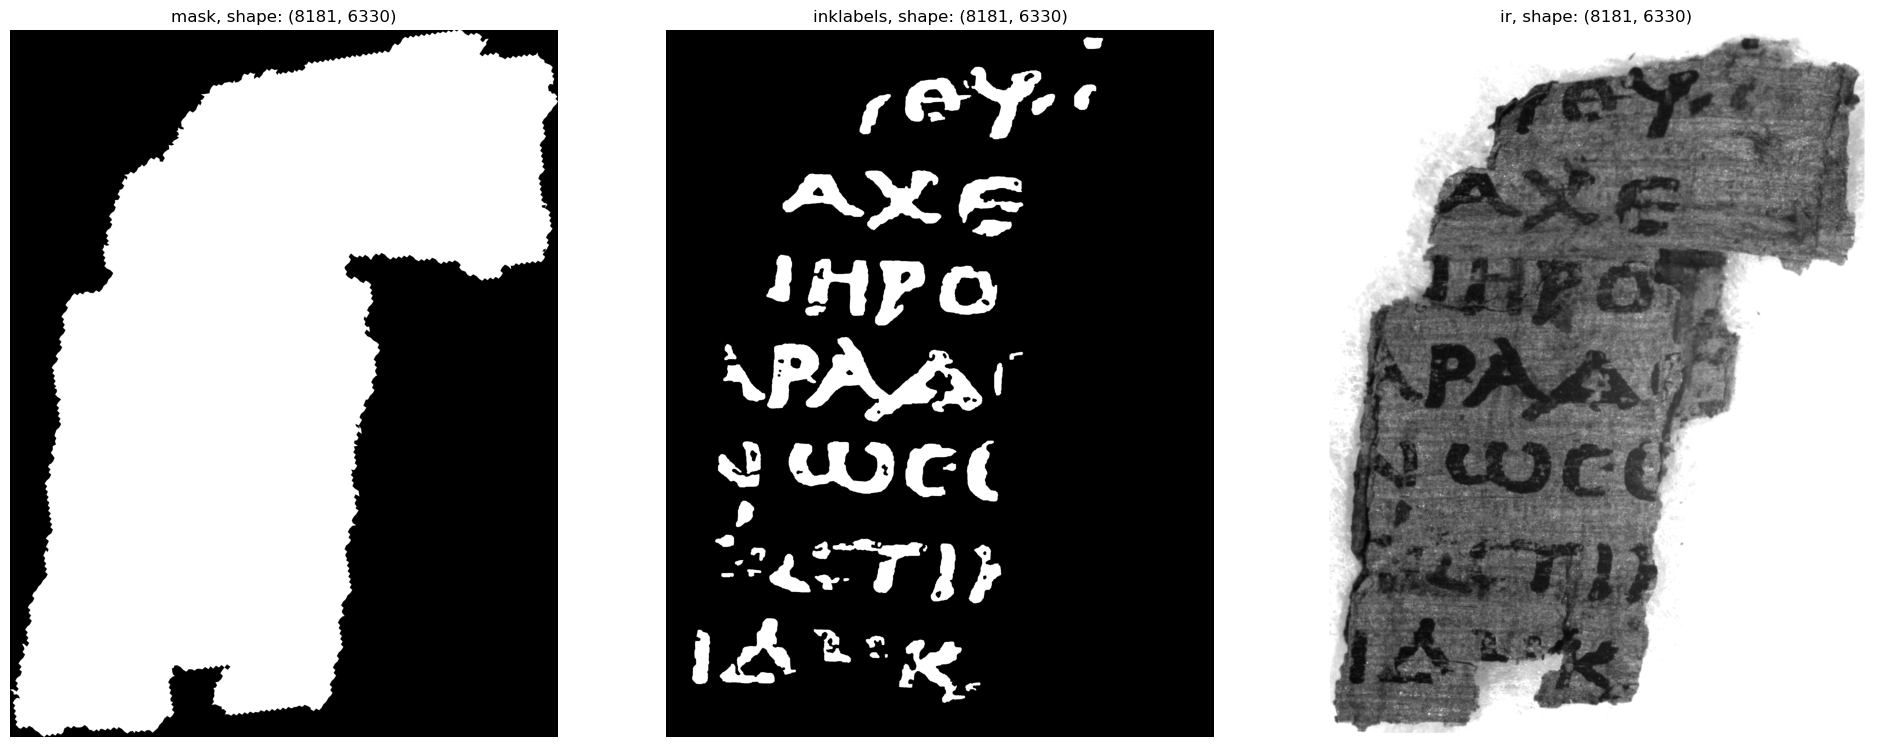

In [5]:
mask = load_png(fragment_id="1", png_name="mask")
inklabels = load_png(fragment_id="1", png_name="inklabels")
ir = load_png(fragment_id="1", png_name="ir")
volume = load_volume(fragment_id="1", z_start=config["z_start"], z_dim=config["z_dim"])
show_pngs(mask, inklabels, ir)
del ir
gc.collect();

## Training validation split

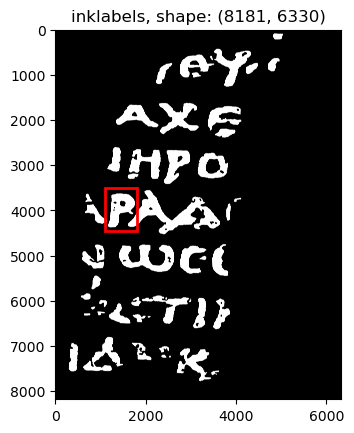

In [6]:
rect = {"x": 1100, "y": 3500, "width": 700, "height": 950}
show_rect_on_inklabels(rect, inklabels)

In [7]:
def get_train_val_masks(mask: np.ndarray, rect: dict, subvolume_size: int) -> Tuple[np.ndarray]:
    # erode mask so that subvolumes will be fully within the mask
    eroded_mask = binary_erosion(mask, structure=np.ones((subvolume_size+10, subvolume_size+10)))
    # binary mask of the rectangle
    rect_mask = np.zeros((mask.shape), dtype=np.uint8)
    rect_mask[rect["y"] : rect["y"] + rect["height"], rect["x"] : rect["x"] + rect["width"]] = 1
    # validation set contains pixels inside the rectangle
    val_mask = eroded_mask * rect_mask
    # dilate rectangle mask so that training subvolumes will have no overlap with rectangle
    dilated_rect_mask = binary_dilation(rect_mask, structure=np.ones((subvolume_size, subvolume_size)))
    train_mask = eroded_mask * (1 - dilated_rect_mask)
    return train_mask, val_mask

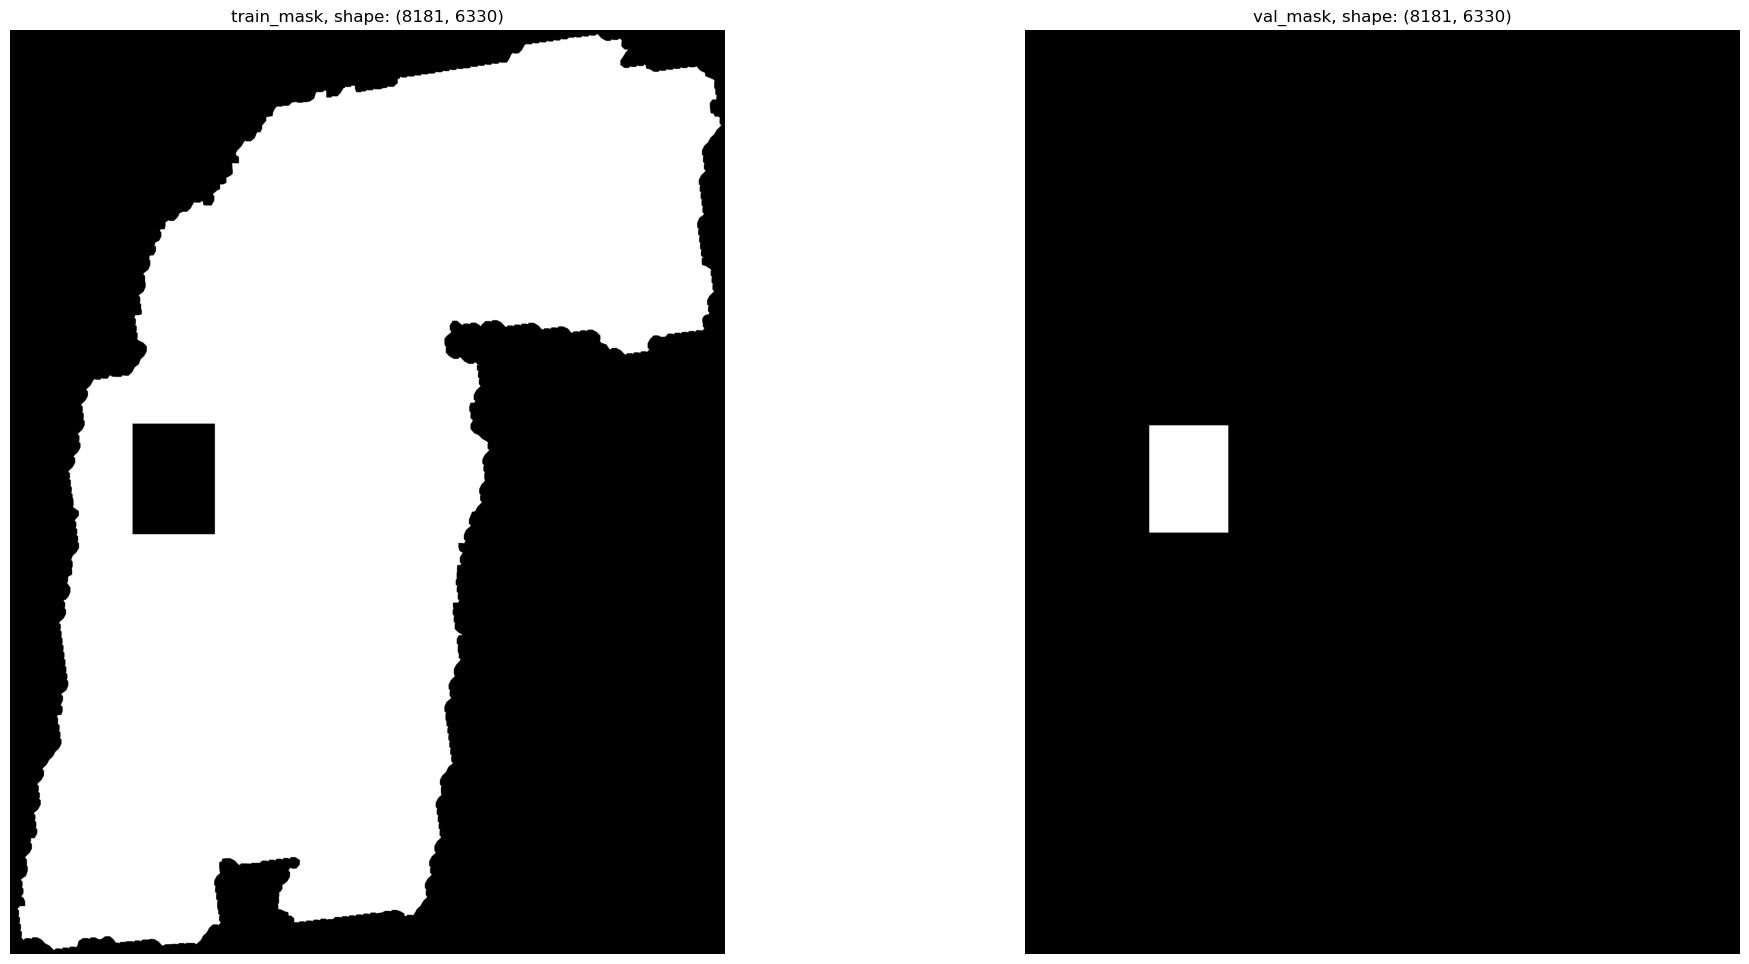

In [8]:
train_mask, val_mask = get_train_val_masks(mask, rect, config["subvolume_size"])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
axs.flatten()
show_array(train_mask, "train_mask", axs[0])
show_array(val_mask, "val_mask", axs[1])
# TODO: class distribution in train and val masks

## Dataset and DataLoaders

In [9]:
train_pixels = list(zip(*np.where(train_mask == 1)))
val_pixels = list(zip(*np.where(val_mask == 1)))
del train_mask, val_mask
gc.collect();

In [10]:
class SubvolumeDataset(Dataset):
    def __init__(self, volume: np.ndarray, inklabels: np.ndarray, pixels: List[Tuple], subvolume_size: int):
        self.volume = volume
        self.inklabels = inklabels
        # pixels in train or validation mask
        self.pixels = pixels
        self.subvolume_size = subvolume_size

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, idx):
        y, x = self.pixels[idx]
        subvolume = self.volume[:,
                                y - self.subvolume_size : y + self.subvolume_size,
                                x - self.subvolume_size : x + self.subvolume_size]
        subvolume = subvolume[np.newaxis, ...]
        subvolume = torch.from_numpy(subvolume).to(torch.float32)
        inklabel = torch.tensor(self.inklabels[y, x], dtype=torch.float32)
        return subvolume, inklabel


def create_data_loaders(batch_size: int, train_pixels: List[Tuple], val_pixels: List[Tuple], dataset_kwargs: dict) -> Tuple[DataLoader]:
    train_ds = SubvolumeDataset(pixels=train_pixels, **dataset_kwargs)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

    val_ds = SubvolumeDataset(pixels=val_pixels, **dataset_kwargs)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())
    return train_loader, val_loader


def show_single_subvolume_batch(subvolume: Tensor, inklabel: Tensor) -> None:
    subvolume = torch.squeeze(subvolume)
    plt.rcParams["figure.dpi"] = 350
    plt.style.use("dark_background")
    num_slices = subvolume.shape[0]
    fig = plt.figure()
    camera = Camera(fig)
    for idx in range(num_slices):
        plt.imshow(subvolume[idx, :, :], cmap="gray")
        plt.text(x=0, y=-1, s=f"slice {idx+1}/{num_slices}", horizontalalignment="center")
        plt.text(x=-6, y=-3, s=f"ink label: {inklabel.item()}")
        plt.axis("off")
        camera.snap()
    animation = camera.animate()
    plt.close(fig)
    fix_video_adjust = "<style> video {margin: 0px; padding: 0px; width:100%; height:auto;} </style>"
    display(HTML(fix_video_adjust + animation.to_html5_video()))
    del animation
    gc.collect()

## Visualize batches 

In [11]:
def find_batches_both_classes(dataloader: DataLoader) -> Tuple[Tuple]:
    batch_inklabel_0 = None
    batch_inklabel_1 = None
    for subvolume, inklabel in train_loader_check:
        if inklabel.item() == 0 and batch_inklabel_0 is None:
            batch_inklabel_0 = subvolume, inklabel
        if inklabel.item() == 1 and batch_inklabel_1 is None:
            batch_inklabel_1 = subvolume, inklabel
        if batch_inklabel_0 is not None and batch_inklabel_1 is not None:
            break
    return batch_inklabel_0, batch_inklabel_1

In [13]:
dataset_kwargs = {"volume": volume, "inklabels": inklabels, "subvolume_size": config["subvolume_size"]}
if not DEBUG:
    train_loader_check, val_loader_check = create_data_loaders(1, train_pixels, val_pixels, dataset_kwargs)
    # batch_inklabel_0, batch_inklabel_1 = find_batches_both_classes(train_loader_check)
    # show_single_subvolume_batch(batch_inklabel_0[0], batch_inklabel_0[1])
    del train_loader_check, val_loader_check  #, batch_inklabel_0
    gc.collect();

In [14]:
if not DEBUG:
    # show_single_subvolume_batch(batch_inklabel_1[0], batch_inklabel_1[1])
    # del batch_inklabel_1
    gc.collect();

## Model

In [15]:
def dice_coef_torch(preds: Tensor, targets: Tensor, beta=0.5, smooth=1e-5) -> float:
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    #comment out if your model contains a sigmoid or equivalent activation layer
    #preds = torch.sigmoid(preds)

    # flatten label and prediction tensors
    preds = preds.view(-1).float()
    targets = targets.view(-1).float()

    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)
    return dice


model = nn.Sequential(
    nn.Conv3d(1, 16, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(16, 32, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(32, 64, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Flatten(start_dim=1),
    nn.LazyLinear(128), nn.ReLU(),
    nn.LazyLinear(1), nn.Sigmoid()
).to(DEVICE)


def train_fn(train_steps: int, train_loader: DataLoader, model: nn.Module, loss_fn: nn.Module, optimizer, logger):
    model.train()
    for i, (x, y) in tqdm(enumerate(train_loader), train_steps):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        if DEBUG and (i > 5):
            break
        if i > train_steps:
            break
        
        optimizer.zero_grad()
        yhat = model(x).squeeze(1)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        logger.log({"train_loss": loss.item(),
                    "train_dice": dice_coef_torch(yhat, y)})


@torch.no_grad()
def val_fn(val_loader: DataLoader, model: nn.Module, loss_fn: nn.Module) -> Tuple[float, float]:
    run_loss = AverageCalc()
    model.eval()
    y_val = []
    yhat_val = []
    
    for i, (x, y) in enumerate(val_loader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        batch_size = x.shape[0]
        
        if DEBUG and (i > 5):
            break

        yhat = model(x).squeeze(1)
        loss = loss_fn(yhat, y)
        run_loss.update(loss.item(), x.shape[0])

        y_val.append(y.cpu())
        yhat_val.append(yhat.cpu())
        
    y_val = torch.cat(y_val)
    yhat_val = torch.cat(yhat_val)
    return run_loss.avg, dice_coef_torch(yhat_val, y_val)


@torch.no_grad()
def generate_ink_pred(val_loader: DataLoader, model: nn.Module, val_pixels: List[Tuple[int, int]]) -> Tensor:
    model.eval()
    output = torch.zeros(IMAGE_SHAPE, dtype=torch.float32)
    for i, (x, y) in enumerate(val_loader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        batch_size = x.shape[0]
        
        if DEBUG and (i > 5):
            break

        yhat = model(x).squeeze(1)
        for j, pred in enumerate(yhat):
            output[val_pixels[i * batch_size + j]] = pred
    return output

C:\Users\gamer\.conda\envs\vesuvius\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
print("About to train")

In [ ]:
import time
loss_fn = nn.BCELoss()
logger = DummyLogger() if DEBUG else create_logger(config)
train_loader, val_loader = create_data_loaders(config["batch_size"], train_pixels, val_pixels, dataset_kwargs)
del train_pixels
gc.collect()

optimizer = Adam(model.parameters())
initial = time.time()
for i in tqdm(range(config["train_rounds"])):
    start = time.time()
    train_fn(config["train_steps"], train_loader, model, loss_fn, optimizer, logger)
    val_loss, val_dice = val_fn(val_loader, model, loss_fn)
    logger.log({"val_loss": val_loss, "val_dice": val_dice})
    end = time.time()
    total = end - start
    print(F"Epoch {i} took in {total:.4} seconds")

final = time.time()
total = final - initial
logger.finish()
print(f"Total training took {total:.4} seconds or {total/60:.4} mins")

In [ ]:
ink_pred = generate_ink_pred(val_loader, model, val_pixels)
del val_pixels
gc.collect()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axs.flatten()
show_array(ink_pred.cpu().numpy(), "ink_pred", axs[0])
show_array(inklabels, "inklabels", axs[1])